In [ ]:
import math
import brian2 as b2
from brian2 import * 
from brian2tools import *
from brian2 import collect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurodynex3 as nd3
from functions_spectrum import *
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import random
%matplotlib inline
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, spike_tools
from neurodynex3.tools import plot_tools, input_factory
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
import tqdm
import pickle
import logging
logging.getLogger(b2.__name__).setLevel(logging.ERROR)
logging.getLogger(nd3.__name__).setLevel(logging.ERROR)

In [2]:
rates_input_const = [4500]*4000 + [6500]*1000 

In [ ]:
start_scope()
C_E = 0.25 *nF
C_I = 0.2 *nF
N_e = 4000
N_i = 1000
gL_E = 25 * nS
gL_I = 20 * nS

eL_E = -65.0 * mV
eL_I = -67.0 * mV

# refractory
refractory_E = 1.3 * ms
refractory_I = 1.3 * ms

# thresholds and exponential behavior
deltaT = 3.48 * mV
VT = -59.9 * mV
V_thr = -30 * mV
V_r = -68.0 * mV

# synaptic reversal potentials 
esynE = 0.0 * mV
esynI = -75.0 * mV  

# rise times
rise_AMPA = 0.5 * ms
rise_GABA = 0.5 * ms

# decay times
decay_AMPA = 2.0 * ms
decay_GABA = 5.0 * ms

# conductances 
gsynE_E = 4.5 * 1.3 * nS
gsynI_E = 6 * 8.75 * nS
gsynE_I = 2.3 * 0.93 * nS
gsynI_I = 3.3 * 6.2 * nS

# latencies
latency_AMPA = 1.5 *ms
latency_GABA = 0.5 *ms

# psx - postsynaptic constant x - added upon presyn. spike
psx_AMPA = 1.0
psx_GABA = 1.0
psx_AMPA_ext = 1.5

alpha = 1.0 / ms

#STDP
dApre = -0.2
dApost = 0.2
taupre = 20 *ms 
taupost = 20 *ms 

In [ ]:
# from attractors_and_oscillation/differential_equations/eif_equations.py (https://github.com/bnra/attractors_and_oscillation)

"""
Equations for the exponential integrate-and-fire neuron with AMPA and GABA type synaptic input based on

- Nicolas Fourcaud-Trocmé, David Hansel, Carl Van Vreeswijk, and Nicolas Brunel. How spike generation mechanisms determine the neuronal response to fluctuating inputs. Journal of neuroscience, 23(37):11628–11640, 2003.

- Nicolas Brunel and Xiao-Jing Wang. What determines the frequency of fast network oscillations with irregular neural discharges? i. synaptic dynamics and excitation-inhibition balance. Journal of neurophysiology, 90(1):415–430, 2003.

- AAshqar :ref: https://github.com/AAshqar/GammaCoupling/blob/develop/NeuronsSpecs/NeuronEqs_DFsepI.py
"""

eq_eif = """
    dV/dt = (-gL*(V-eL) + gL*deltaT*exp((V-VT)/deltaT) - IsynE - IsynI - IsynE_ext + Iext) / C : volt
    IsynE_ext = gsynE * (V - esynE) * synE_ext : amp
    IsynE = gsynE * (V - esynE) * synE : amp
    IsynI = gsynI * (V - esynI) * synI : amp
    dsynE_ext/dt = alpha * x_AMPA_ext - synE_ext/decay_AMPA : 1
    dsynE/dt = alpha * x_AMPA - synE/decay_AMPA : 1
    dsynI/dt = alpha * x_GABA - synI/decay_GABA : 1
    dx_AMPA_ext/dt = -x_AMPA_ext/rise_AMPA : 1
    dx_GABA/dt = -x_GABA/rise_GABA : 1
    dx_AMPA/dt = -x_AMPA/rise_AMPA : 1
    Iext : amp
    """

eq_eif_E = (
    eq_eif.replace("gsynE", "gsynE_E")
    .replace("gsynI", "gsynI_E")
    .replace("C", "C_E")
    .replace("gL", "gL_E")
    .replace("eL", "eL_E")
)

eq_eif_I = (
    eq_eif.replace("gsynE", "gsynE_I")
    .replace("gsynI", "gsynI_I")
    .replace("C", "C_I")
    .replace("gL", "gL_I")
    .replace("eL", "eL_I")
)


pre_eif_E = "x_AMPA += psx_AMPA"
pre_eif_I = "x_GABA += psx_GABA"
pre_eif_Pois = "x_AMPA_ext += psx_AMPA_ext"


Syn_model_I = '''
            w: 1
            w_max : 1
            plastic : 1 (shared)
            notplastic : 1 (shared)
            dApre/dt = - (Apre / taupre) *int(plastic) : 1 (event-driven)
            dApost/dt = - (Apost / taupost) *int(plastic): 1 (event-driven)
        '''

Pre_eq_I = '''
            x_GABA = x_GABA + psx_GABA*int(notplastic) + w*int(plastic)
            Apre = Apre + dApre*int(plastic)            
            w = clip(w + Apost, 0, w_max)                                        
        ''' 

Post_eq_I = '''
            Apost = Apost + dApost*int(plastic)    
            w = clip(w + Apre, 0, w_max) 
        '''

In [ ]:
defaultclock.dt = 0.1*msecond                       # timestep


E = NeuronGroup(N_e, eq_eif_E, threshold="V>V_thr", reset="V = V_r", refractory=refractory_E, method="rk2")
I = NeuronGroup(N_i, eq_eif_I, threshold="V>V_thr", reset="V = V_r", refractory=refractory_I, method="rk2")

E.V = eL_E
I.V = eL_I


P = PoissonGroup(5000, rates=rates_input_const*Hz)

# creating synapses

S_I_E = Synapses(I, E, model=Syn_model_I, on_pre=Pre_eq_I, on_post=Post_eq_I, delay=latency_GABA)
S_P_E = Synapses(P[0:4000], E, on_pre=pre_eif_Pois, delay=latency_AMPA)
S_P_I = Synapses(P[4000:5000], I, on_pre=pre_eif_Pois, delay=latency_AMPA)
S_P_E.connect(j='i')
S_P_I.connect(j='i')


S_E_E = Synapses(E, E, on_pre=pre_eif_E, delay=latency_AMPA)
S_E_I = Synapses(E, I, on_pre=pre_eif_E, delay=latency_AMPA)
S_I_I = Synapses(I, I, on_pre=pre_eif_I, delay=latency_GABA)
S_E_E.connect(p = 0.01)
S_E_I.connect(p = 0.1)
S_I_E.connect(p = 0.1)
S_I_I.connect(p = 0.1)

S_I_E.w = 'rand() * 1'
S_I_E.w_max = 1

In [ ]:
state_monitor_V_E = StateMonitor(E, 'V', record=True)
state_monitor_V_I = StateMonitor(I, 'V', record=True)
spikes_E = SpikeMonitor(E)
spikes_I = SpikeMonitor(I)
spikes_input = SpikeMonitor(P)
rate_E = PopulationRateMonitor(E)
rate_I = PopulationRateMonitor(I)
state_monitor_Isyn = StateMonitor(I, 'IsynI', record=True)
state_monitor_Isyn_E = StateMonitor(E, 'IsynE', record=True)

W_evolution_I_E = StateMonitor(S_I_E, 'w', record = True, dt=100*ms)

In [ ]:
S_I_E.plastic = 0
S_I_E.notplastic = 1
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
rate_E.active = False
rate_I.active = False
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False

W_evolution_I_E.active = False
run(200*msecond, report='text')

S_I_E.plastic = 0
S_I_E.notplastic = 1
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = True
spikes_I.active = True
spikes_input.active = False
rate_E.active = True
rate_I.active = True
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False

W_evolution_I_E.active = False
run(2000*msecond, report='text')

state_monitor_V_E.active = True
state_monitor_V_I.active = True
spikes_E.active = True
spikes_I.active = True
spikes_input.active = True
rate_E.active = True
rate_I.active = True
state_monitor_Isyn.active = True
state_monitor_Isyn_E.active = True
W_evolution_I_E.active = True

run(500*msecond, report='text')

Starting simulation at t=0. s for a duration of 200. ms
200. ms (100%) simulated in 1s
Starting simulation at t=200. ms for a duration of 2. s
1.2995 s (64%) simulated in 10s, estimated 5s remaining.
2. s (100%) simulated in 15s
Starting simulation at t=2.2 s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


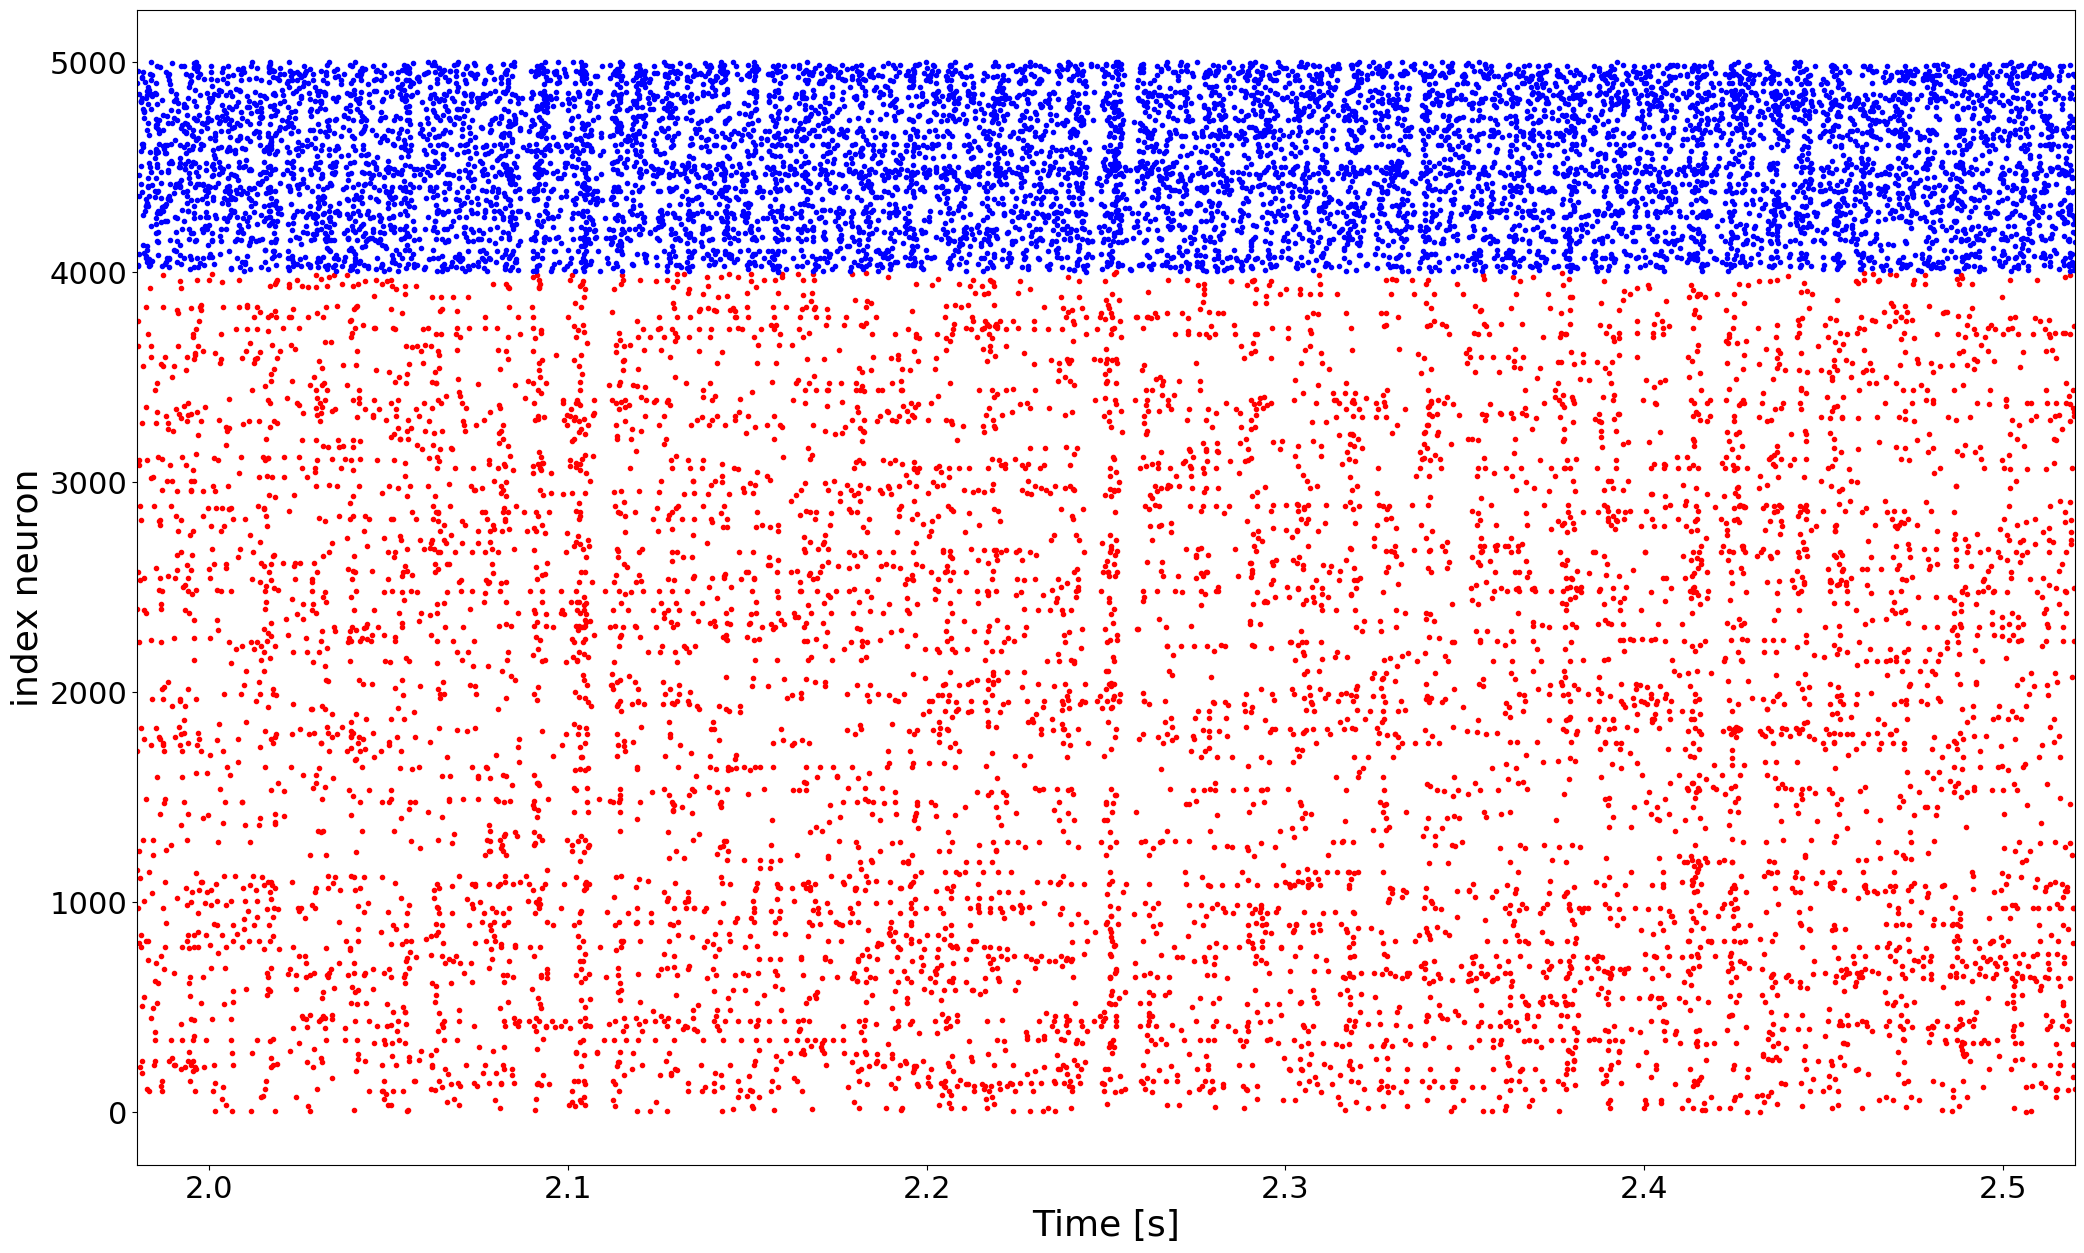

In [ ]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E.t, spikes_E.i, '.', color = 'r')
plt.plot(spikes_I.t, spikes_I.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(1.98, 2.52)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [11]:
E_self = []
for i,j in zip(S_E_E.i, S_E_E.j):
    if i == j:
        # print(i,j)
        E_self.append(i)

In [11]:
I_self = []
for i,j in zip(S_I_I.i, S_I_I.j):
    if i == j:
        I_self.append(i)

In [12]:
E_I_self = []
I_E_self = []
for i,j in zip(S_I_E.i[:300000], S_I_E.j[:300000]):
    if i in I_self and j in E_self and (j,i) in zip(S_E_I.i[:300000], S_E_I.j[:300000]):
        print(i,j)
        print('Num of spikes neuron %s E: {}'.format(spikes_E.count[j]) % j)
        print('Num of spikes neuron %s I: {}'.format(spikes_I.count[i]) % i)
        I_E_self.append(i)
        E_I_self.append(j)

38 2424
Num of spikes neuron 2424 E: 0
Num of spikes neuron 38 I: 109
52 948
Num of spikes neuron 948 E: 1
Num of spikes neuron 52 I: 0
94 2958
Num of spikes neuron 2958 E: 5
Num of spikes neuron 94 I: 6
96 1243
Num of spikes neuron 1243 E: 5
Num of spikes neuron 96 I: 17
356 1907
Num of spikes neuron 1907 E: 4
Num of spikes neuron 356 I: 17
372 2424
Num of spikes neuron 2424 E: 0
Num of spikes neuron 372 I: 0
378 426
Num of spikes neuron 426 E: 0
Num of spikes neuron 378 I: 206
379 2346
Num of spikes neuron 2346 E: 7
Num of spikes neuron 379 I: 26
397 1855
Num of spikes neuron 1855 E: 7
Num of spikes neuron 397 I: 0
397 1907
Num of spikes neuron 1907 E: 4
Num of spikes neuron 397 I: 0
413 1855
Num of spikes neuron 1855 E: 7
Num of spikes neuron 413 I: 18
438 2351
Num of spikes neuron 2351 E: 1
Num of spikes neuron 438 I: 138
440 317
Num of spikes neuron 317 E: 21
Num of spikes neuron 440 I: 57
444 988
Num of spikes neuron 988 E: 7
Num of spikes neuron 444 I: 0
444 1180
Num of spikes n

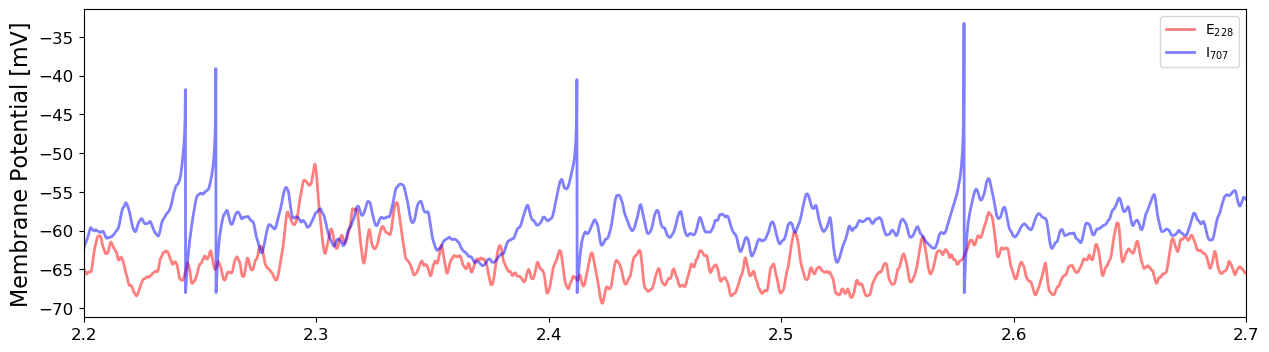

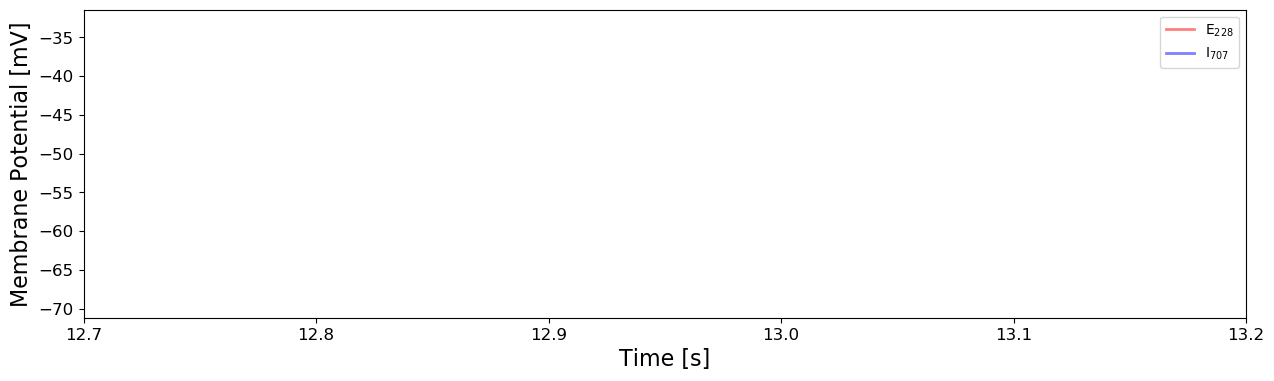

In [14]:
fig = figure(figsize=(15, 4))
for kk in [228]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [707]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.2,2.7)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = figure(figsize=(15, 4))
for kk in [228]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [707]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(12.7,13.2)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [15]:
E_I_full_spikes_IE = [(spikes_E.count[i],spikes_I.count[j]) for i, j in zip(E_I_self, I_E_self)]
print(E_I_full_spikes_IE)

[(0, 109), (1, 0), (5, 6), (5, 17), (4, 17), (0, 0), (0, 206), (7, 26), (7, 0), (4, 0), (7, 18), (1, 138), (21, 57), (7, 0), (0, 0), (1, 20), (1, 89), (0, 81), (0, 58), (4, 40)]


In [16]:
E_I_full_IE = [(i,j) for i, j in zip(E_I_self, I_E_self)]
print(E_I_full_IE)

[(2424, 38), (948, 52), (2958, 94), (1243, 96), (1907, 356), (2424, 372), (426, 378), (2346, 379), (1855, 397), (1907, 397), (1855, 413), (2351, 438), (317, 440), (988, 444), (1180, 444), (2351, 494), (2351, 595), (426, 598), (544, 704), (1907, 715)]


Num of spikes neuron 1733 E: 75
Num of spikes neuron 197 I: 25


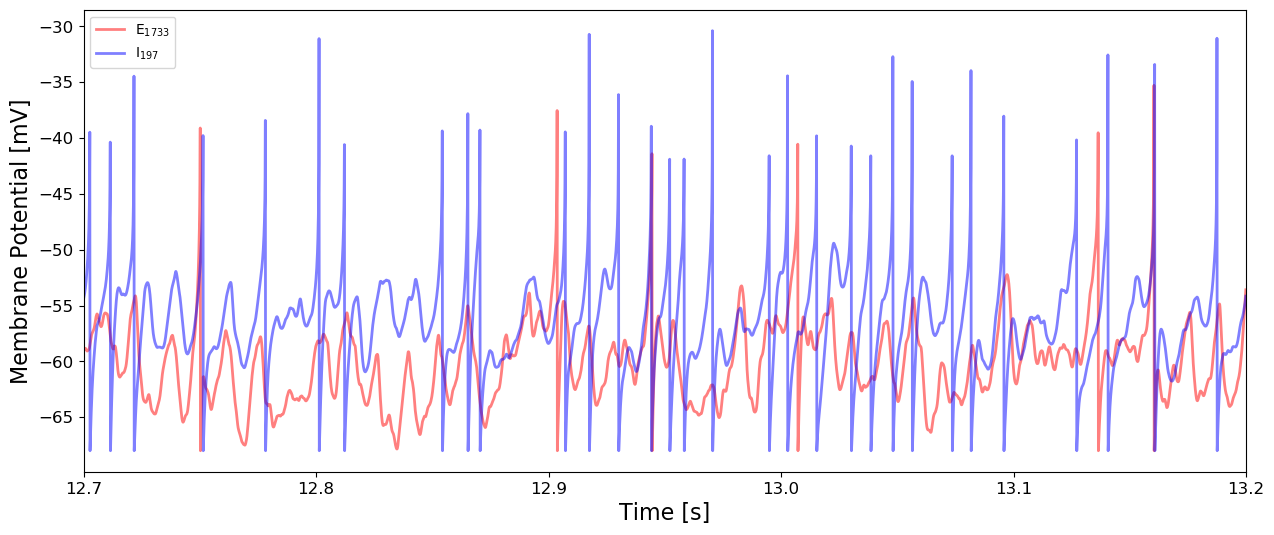

In [69]:
fig = figure(figsize=(15, 6))
for kk in [1733]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [197]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.2,2.7)
xlim(12.7,13.2)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [21]:
max(rate_E.rate)

35. * hertz

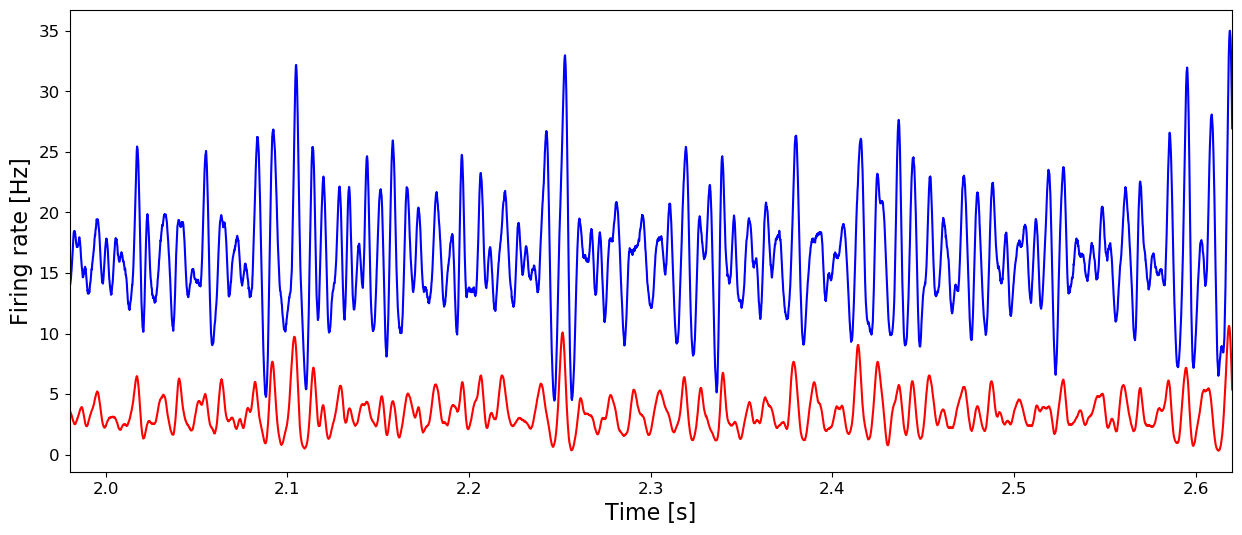

In [30]:
fig = figure(figsize=(15, 6))
smooth_width = 1*ms
plt.plot(rate_E.t, rate_E.smooth_rate(window='gaussian', width=1 *msecond), color = 'r')
plt.plot(rate_I.t, rate_I.smooth_rate(window='gaussian', width=1 *msecond), color = 'b')
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
# ylim(-2,45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [31]:
print('Mean firing rate I =', np.mean(rate_I.rate), 'Hz')
print('Mean firing rate E =', np.mean(rate_E.rate), 'Hz')

Mean firing rate I = 16.192 Hz
Mean firing rate E = 3.483 Hz


In [32]:
spikes_E_after = SpikeMonitor(E)
spikes_I_after = SpikeMonitor(I)
rate_E_after = PopulationRateMonitor(E)
rate_I_after = PopulationRateMonitor(I)

In [ ]:
S_I_E.plastic = 1
S_I_E.notplastic = 0
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
spikes_E_after.active = False
spikes_I_after.active = False
rate_E.active = False
rate_I.active = False
rate_E_after.active = False
rate_I_after.active = False
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False
W_evolution_I_E.active = False
run(8000*msecond, report='text')

state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
spikes_E_after.active = True
spikes_I_after.active = True
rate_E.active = False
rate_I.active = False
rate_E_after.active = True
rate_I_after.active = True
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False
W_evolution_I_E.active = True
run(2000*msecond, report='text')


state_monitor_V_E.active = True
state_monitor_V_I.active = True
spikes_E_after.active = True
spikes_I_after.active = True
rate_E_after.active = True
rate_I_after.active = True
state_monitor_Isyn.active = True
state_monitor_Isyn_E.active = True
W_evolution_I_E.active = True
run(500*msecond, report='text')


Starting simulation at t=2.7 s for a duration of 8. s
1.312 s (16%) simulated in 10s, estimated 51s remaining.
2.5923 s (32%) simulated in 20s, estimated 42s remaining.
3.8673 s (48%) simulated in 30s, estimated 32s remaining.
5.1689 s (64%) simulated in 40s, estimated 22s remaining.
6.449 s (80%) simulated in 50s, estimated 12s remaining.
7.7457 s (96%) simulated in 1m 0s, estimated 2s remaining.
8. s (100%) simulated in 1m 1s
Starting simulation at t=10.7 s for a duration of 2. s
1.1453 s (57%) simulated in 10s, estimated 7s remaining.
2. s (100%) simulated in 17s
Starting simulation at t=12.7 s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


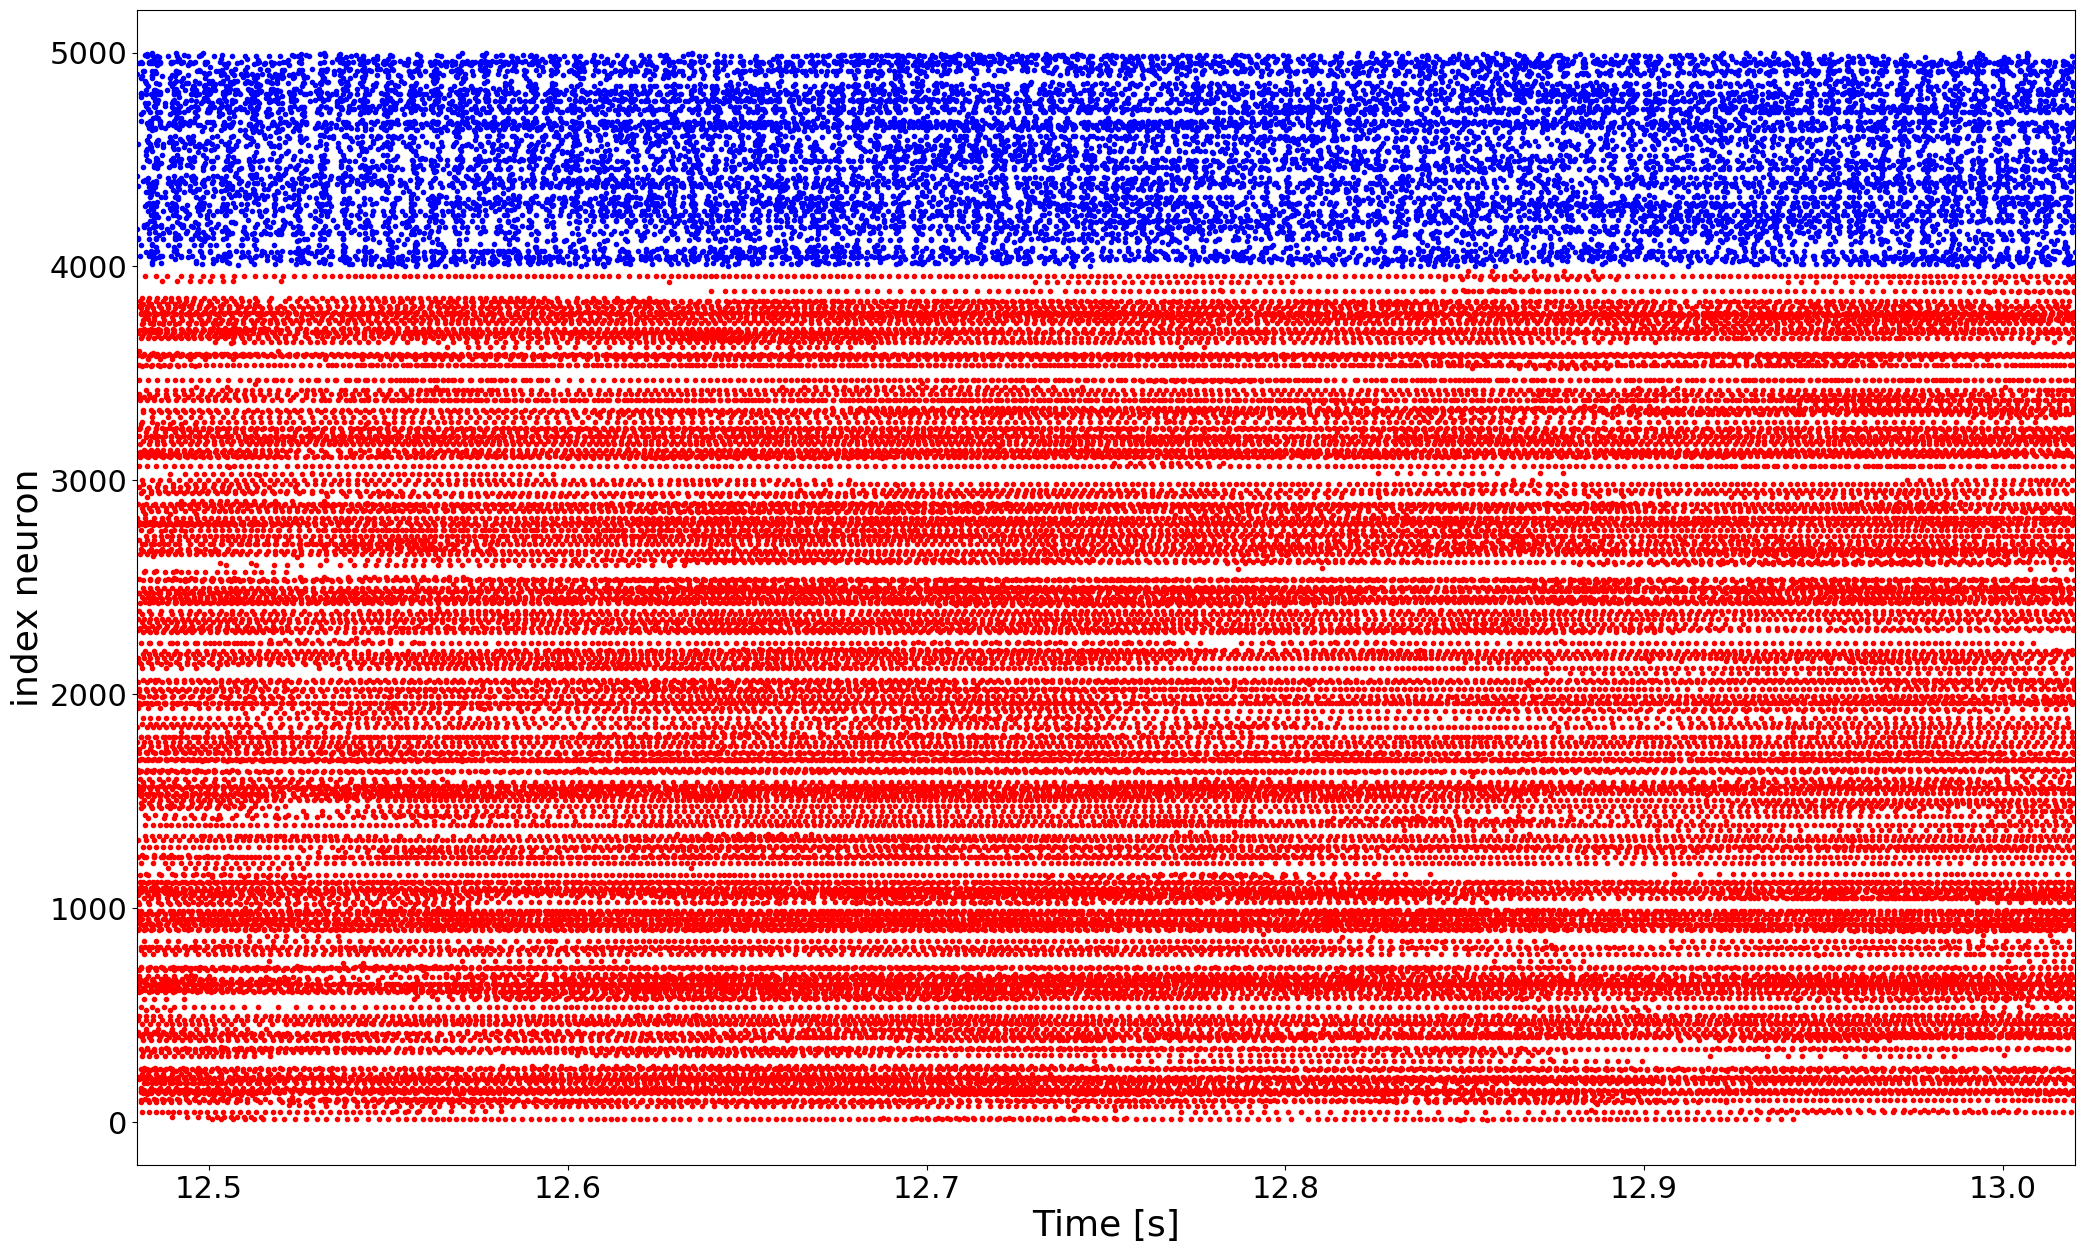

In [ ]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E_after.t, spikes_E_after.i, '.', color = 'r')
plt.plot(spikes_I_after.t, spikes_I_after.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(12.48, 13.02)
ylim(-200, 5200)

plt.xticks(fontsize=22)
plt.yticks([0, 1000, 2000, 3000, 4000, 5000],fontsize=22)
plt.show()

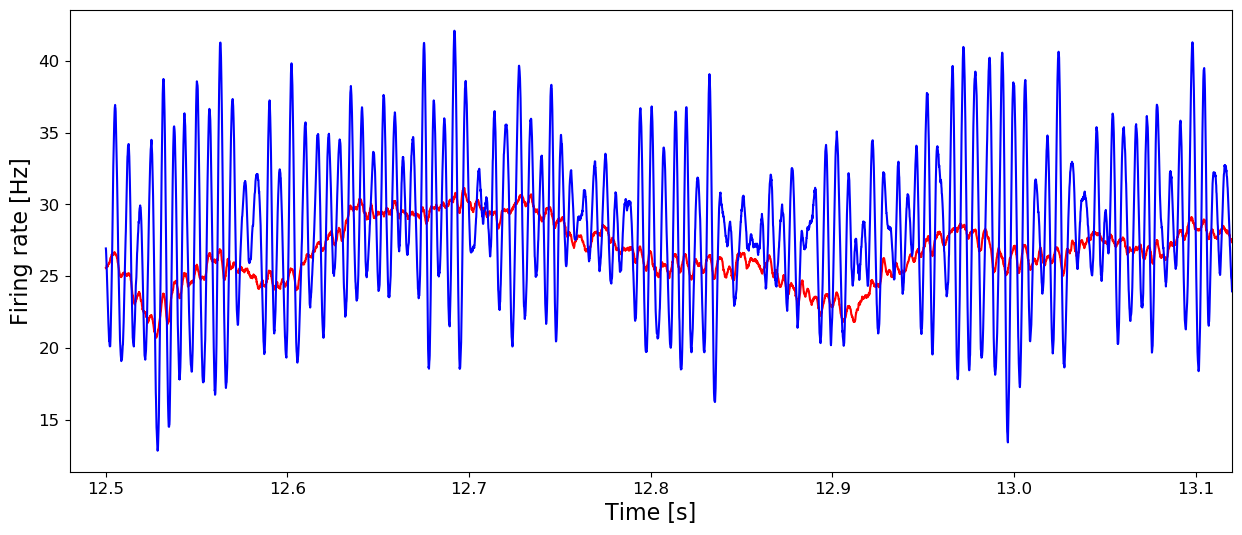

In [ ]:
fig = figure(figsize=(15, 6))
smooth_width = 1*ms
plt.plot(rate_E_after.t[18000:], rate_E_after.smooth_rate(window='gaussian', width=1 *msecond)[18000:], color = 'r')
plt.plot(rate_I_after.t[18000:], rate_I_after.smooth_rate(window='gaussian', width=1 *msecond)[18000:], color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(12.48, 13.12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [36]:
print('Mean firing rate =', np.mean(rate_I_after.rate), 'Hz')
print('Mean firing rate =', np.mean(rate_E_after.rate), 'Hz')

Mean firing rate = 27.6692 Hz
Mean firing rate = 25.6214 Hz


In [38]:
weights_before = []
weights_after = []
for i in W_evolution_I_E.w:
    weights_before.append(i[0])
    weights_after.append(i[-1])

Text(0.5, 0, 'Num')

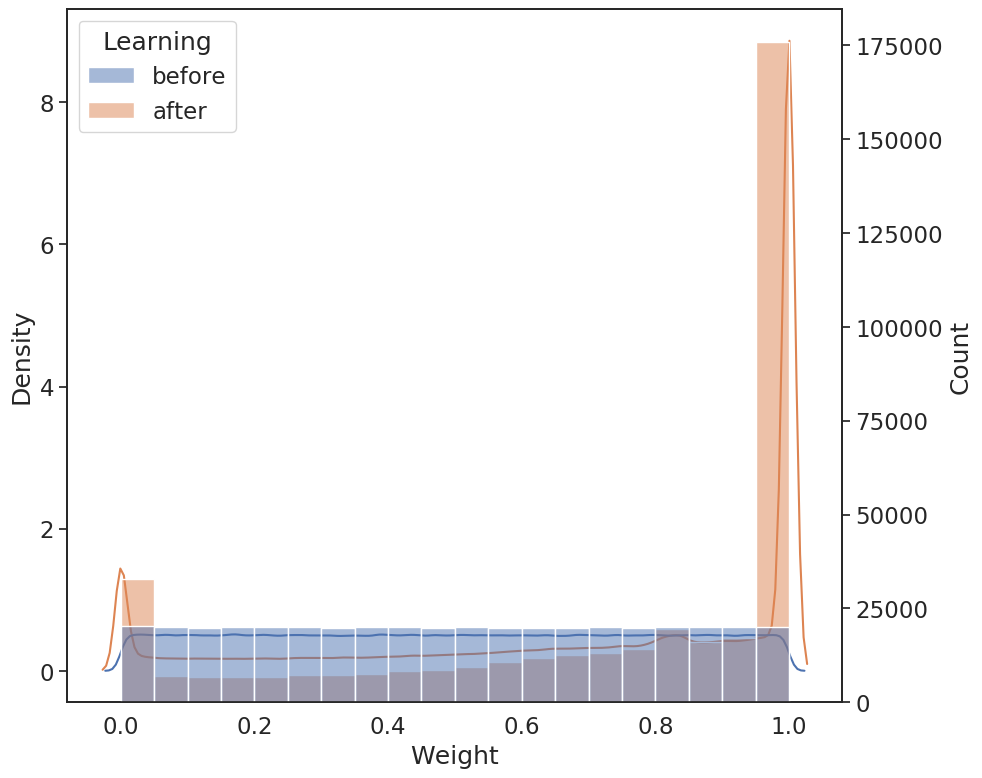

In [ ]:
import seaborn as sns
sns.set(font_scale=1.5, style='white')
nums = weights_before + weights_after
stdp = ['before']*len(weights_before) + ['after']*len(weights_after)
df = pd.DataFrame({"Weight": nums, "Learning": stdp})
fig, ax1 = plt.subplots(figsize=(10, 9))
ax2 = ax1.twinx()
sns.histplot(data=df, x="Weight", discrete=False, ax=ax2, bins = 20, alpha = 0.5, hue = "Learning")
sns.kdeplot(data=df, x="Weight", bw_adjust=.35,ax=ax1,  hue = "Learning", legend = False)


plt.xlabel("Num")

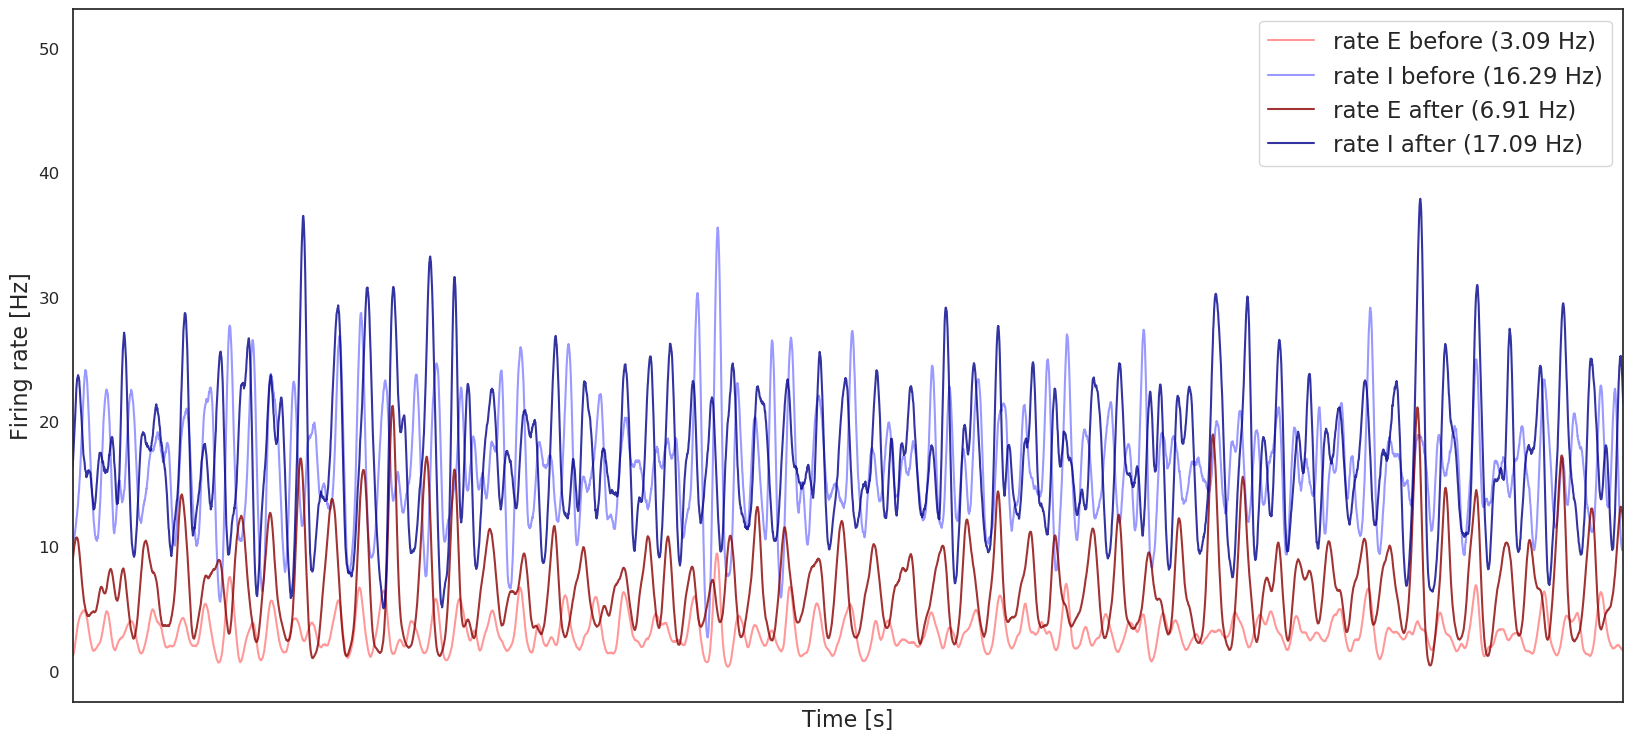

In [ ]:
fig = figure(figsize=(20, 9))
smooth_width = 1*ms
plt.plot(rate_E.t, rate_E.smooth_rate(window='gaussian', width=1 *msecond), color = 'red', alpha = 0.4, label = 'rate E before (%s Hz)'  % np.round(np.mean(rate_E.rate),2))
plt.plot(rate_I.t, rate_I.smooth_rate(window='gaussian', width=1 *msecond), color = 'blue', alpha = 0.4, label = 'rate I before (%s Hz)'  % np.round(np.mean(rate_I.rate),2))
plt.plot(rate_E.t, rate_E_after.smooth_rate(window='gaussian', width=1 *msecond), color = 'darkred', alpha = 0.8, label = 'rate E after (%s Hz)'  % np.round(np.mean(rate_E_after.rate),2))
plt.plot(rate_I.t, rate_I_after.smooth_rate(window='gaussian', width=1 *msecond), color = 'darkblue', alpha = 0.8, label = 'rate I after (%s Hz)'  % np.round(np.mean(rate_I_after.rate),2))
plt.legend()
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
delta_f = 1/2.5 * Hz
T_init = 60 * ms
k = 1024
T_signal = 2500 *ms
T_sim = k * T_signal + T_init
data = rate_I.rate/b2.Hz
delta_t = rate_I.clock.dt
f_max = 1./(2. * delta_t)
N_signal = int(2 * f_max / delta_f)
T_signal = N_signal * delta_t
N_init = 0
N_required = k * N_signal + N_init
N_data = len(data)

1000 2500.5
mean_firing_rate:0.0
59
130


(<Figure size 640x480 with 1 Axes>, [59, 130])

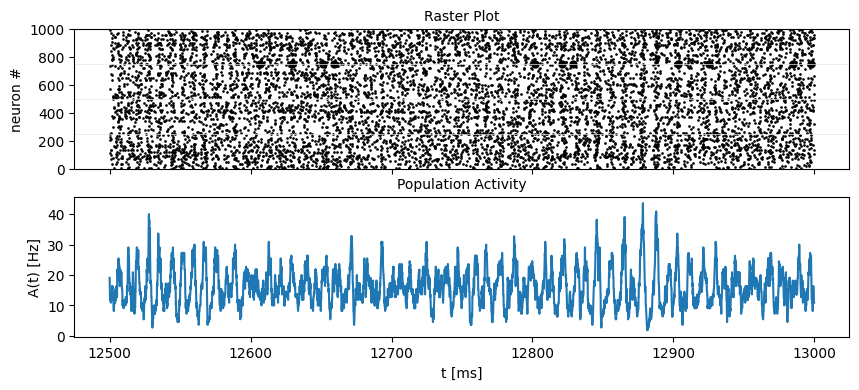

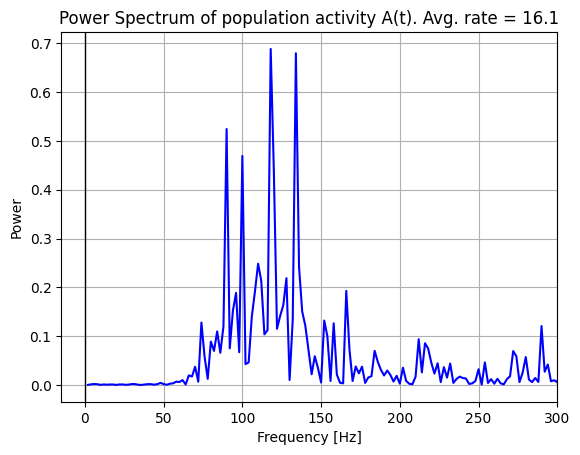

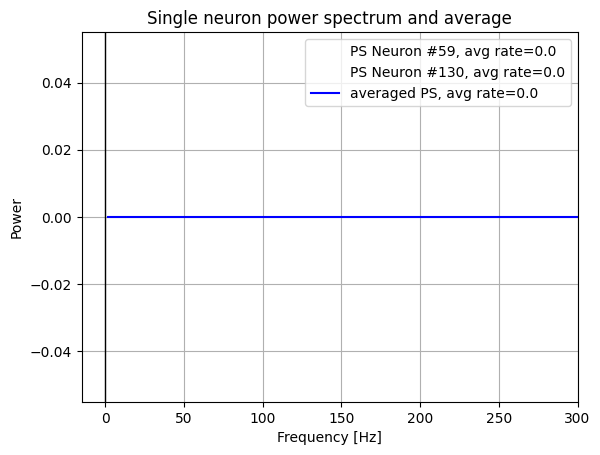

In [30]:
plot_tools.plot_network_activity(rate_I, spikes_I, t_min = 12500 *ms, spike_train_idx_list=list(range(1000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_I, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_I, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 1000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=2)

4000 2500.5
mean_firing_rate:0.0
713
2143
3124


(<Figure size 640x480 with 1 Axes>, [713, 2143, 3124])

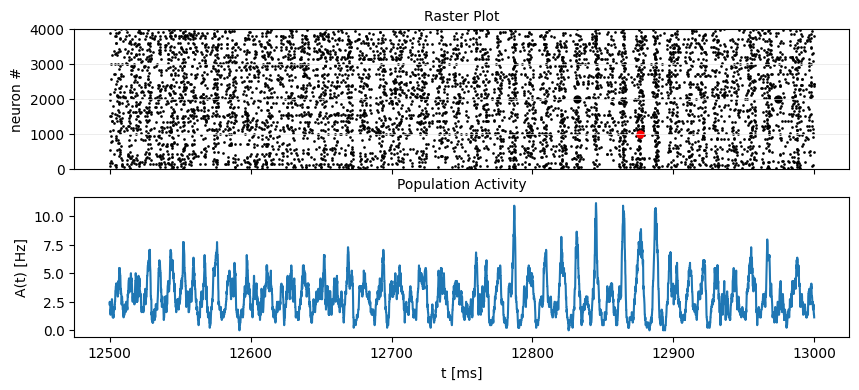

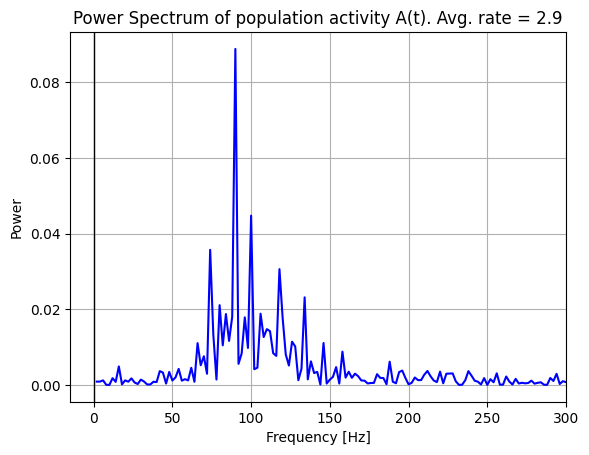

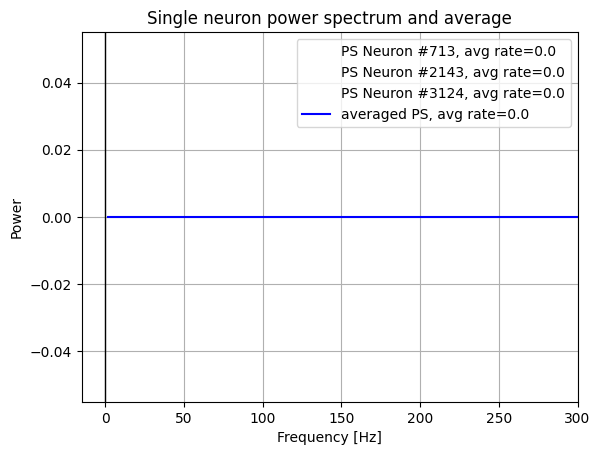

In [31]:
plot_tools.plot_network_activity(rate_E, spikes_E, t_min = 12500 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)

4000 2500.5
mean_firing_rate:0.0
1051
231
1531


(<Figure size 640x480 with 1 Axes>, [1051, 231, 1531])

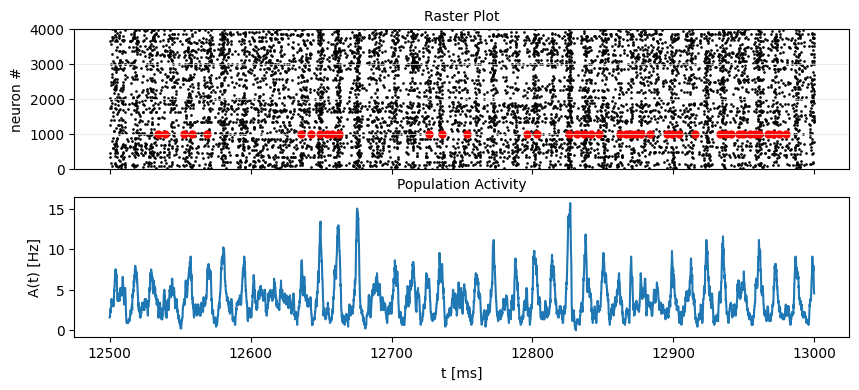

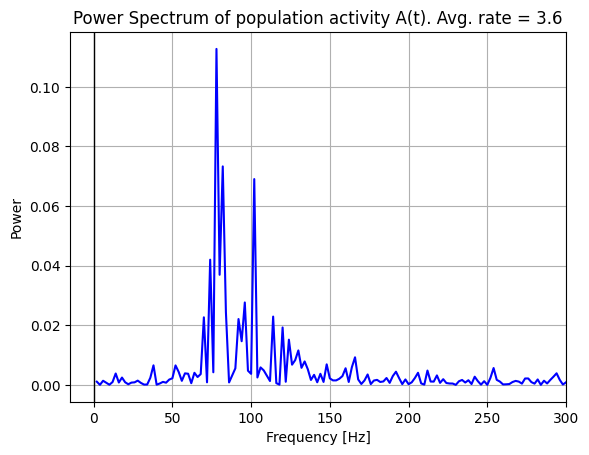

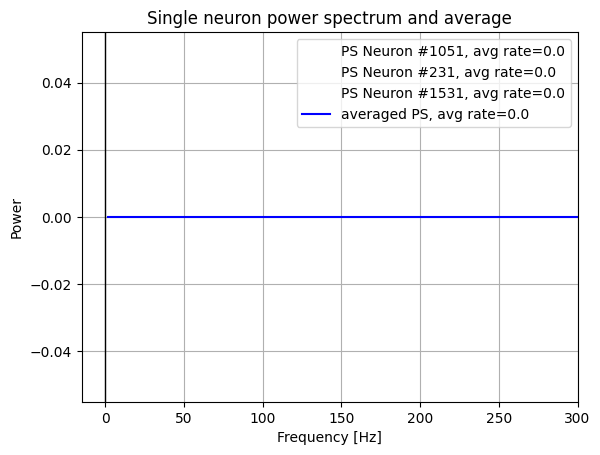

In [58]:
plot_tools.plot_network_activity(rate_E_after, spikes_E_after, t_min = 12500 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E_after, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E_after, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)

In [40]:
E_self = []
for i,j in zip(S_E_E.i, S_E_E.j):
    if i == j:
        # print(i,j)
        E_self.append(i)

In [41]:
I_self = []
for i,j in zip(S_I_I.i, S_I_I.j):
    if i == j:
        I_self.append(i)

In [42]:
E_I_self = []
I_E_self = []
for i,j in zip(S_I_E.i[:300000], S_I_E.j[:300000]):
    if i in I_self and j in E_self and (j,i) in zip(S_E_I.i[:300000], S_E_I.j[:300000]):
        print(i,j)
        print('Num of spikes neuron %s E: {}'.format(spikes_E.count[j]) % j)
        print('Num of spikes neuron %s I: {}'.format(spikes_I.count[i]) % i)
        I_E_self.append(i)
        E_I_self.append(j)

18 1789
Num of spikes neuron 1789 E: 0
Num of spikes neuron 18 I: 7
46 2979
Num of spikes neuron 2979 E: 0
Num of spikes neuron 46 I: 25
86 1718
Num of spikes neuron 1718 E: 16
Num of spikes neuron 86 I: 167
117 1341
Num of spikes neuron 1341 E: 0
Num of spikes neuron 117 I: 11
122 1782
Num of spikes neuron 1782 E: 0
Num of spikes neuron 122 I: 33
213 2492
Num of spikes neuron 2492 E: 1
Num of spikes neuron 213 I: 52
220 2122
Num of spikes neuron 2122 E: 5
Num of spikes neuron 220 I: 210
288 196
Num of spikes neuron 196 E: 1
Num of spikes neuron 288 I: 10
288 1150
Num of spikes neuron 1150 E: 0
Num of spikes neuron 288 I: 10
299 1171
Num of spikes neuron 1171 E: 3
Num of spikes neuron 299 I: 0
331 1211
Num of spikes neuron 1211 E: 0
Num of spikes neuron 331 I: 70
383 2953
Num of spikes neuron 2953 E: 0
Num of spikes neuron 383 I: 127
391 121
Num of spikes neuron 121 E: 4
Num of spikes neuron 391 I: 22
391 312
Num of spikes neuron 312 E: 2
Num of spikes neuron 391 I: 22
406 1211
Num of 

Num of spikes neuron 1733 E: 75
Num of spikes neuron 197 I: 25


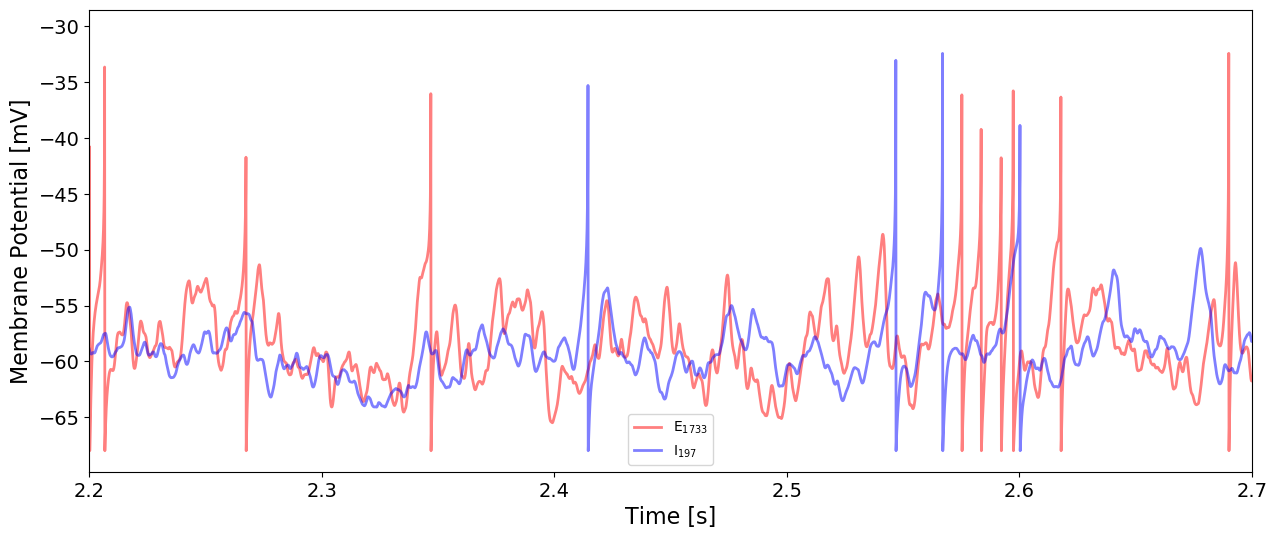

In [ ]:
fig = figure(figsize=(15, 6))
for kk in [1733]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [197]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.2,2.7)
# xlim(12.7,13.2)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

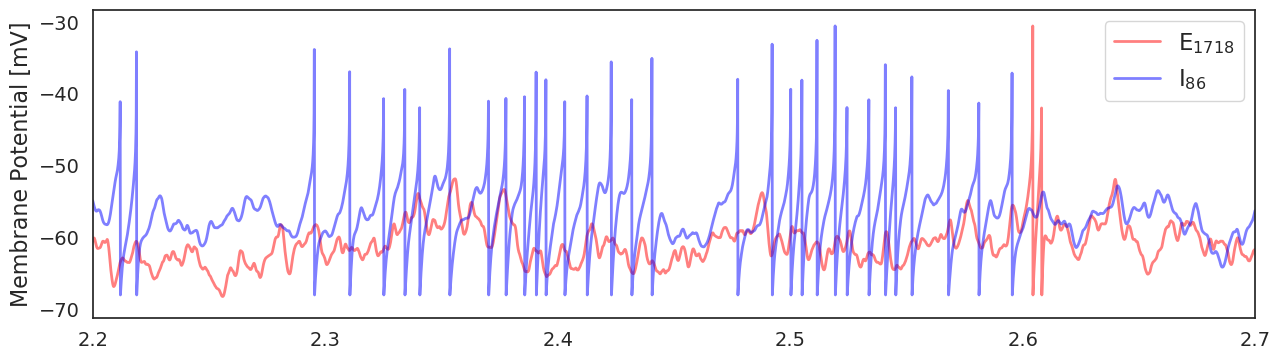

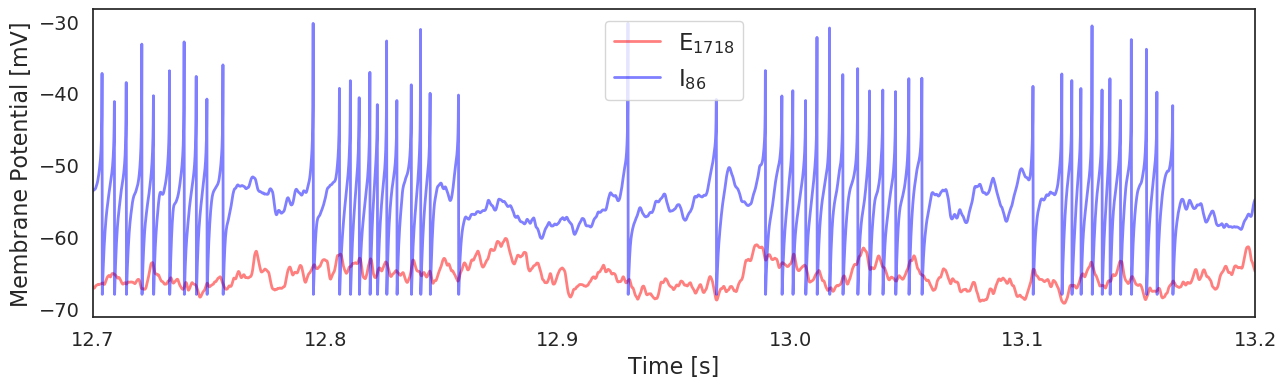

In [45]:
fig = figure(figsize=(15, 4))
for kk in [1718]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'red', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [86]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='blue', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.2,2.7)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig = figure(figsize=(15, 4))
for kk in [1718]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'red', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [86]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='blue', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(12.7,13.2)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()